# Visualize overall similarity in gene expression in publicly available RNA-seq data from *Amblyomma americanum*

This notebook produces a PCA plot that shows how similar different samples of RNA-seq data from *A. americanum* are to each other.
The purpose of this visualization is to assess which samples cluster more by study than by biological traits (like sex or tissue type of the sample).
If the samples cluster more by study than by biological traits, this clustering may be driven by batch effects rather than differences in gene expression itself.

## Notebook set up

In [1]:
# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)

In [2]:
setwd("..")

In [4]:
library(tidyverse, warn.conflicts = F)
library(DESeq2, warn.conflicts = F)

## Read in gene counts

In [5]:
counts <- read_tsv("outputs/counts/raw_counts.tsv", show_col_types = F)
counts_summary <- counts %>% filter(grepl("^__", gene)) # keep the summary rows produced by htseq
counts <- counts %>% filter(!grepl("^__", gene)) # filter out summary rows produced by htseq

## Read in sample metadata

In [6]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F)

In [7]:
arthropod_cell_line <- c("SRP052091", "SRP052078", "SRP052108", "SRP052123", "SRP052154", "SRP052114", "SRP052145", "SRP052106")

In [8]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F) %>%
  select(library_name, experiment_title, study_title, study_accession, sex, host_meal, tissue, blood_meal_hour, blood_meal_hour_range, total_spots) %>%
  group_by(library_name) %>%
  mutate(total_spots = sum(total_spots)) %>%
  mutate(blood_meal_hour_range = factor(blood_meal_hour_range, levels = c("0", "12_48", "72_144", "168_264", "none"))) %>%
  distinct() %>%
  mutate(study_accession = ifelse(study_accession %in% arthropod_cell_line, "Arthropod Cell Line", study_accession))

In [9]:
# rearrange metadata so that it matches the order of the counts dataframe
metadata <- metadata[order(match(metadata$library_name, colnames(counts))), ]

## Differential expression with DESeq2

In [10]:
# generate dds (deseq2 data set) from gene counts
dds <- DESeqDataSetFromMatrix(counts %>% column_to_rownames("gene"),
                              colData = metadata,
                              design = ~ study_accession)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [11]:
# generate ds (deseq) object from the deseq2 data set
ds <- DESeq(dds, test="Wald")

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and t

In [12]:
# check the results names to see which variables were compared in the model
resultsNames(ds)

[1] "Intercept"                                       
[2] "study_accession_SRP032795_vs_Arthropod.Cell.Line"
[3] "study_accession_SRP051699_vs_Arthropod.Cell.Line"
[4] "study_accession_SRP091404_vs_Arthropod.Cell.Line"
[5] "study_accession_SRP446981_vs_Arthropod.Cell.Line"

## Assess initially with PCA

In [13]:
# transform gene counts with variance stabilized transformation to make vsd (variance stabilized deseq object)
vsd <- vst(dds, blind=FALSE)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [14]:
accent_v2 <- c('#5088C5', '#F28360', '#3B9886', '#F7B846', 
               '#7A77AB', '#F898AE', '#C6E7F4', '#F8C5C1',
               '#B5BEA4', '#F5E4BE', '#DCBFFC', '#F5CBE4')

using ntop=500 top features by variance



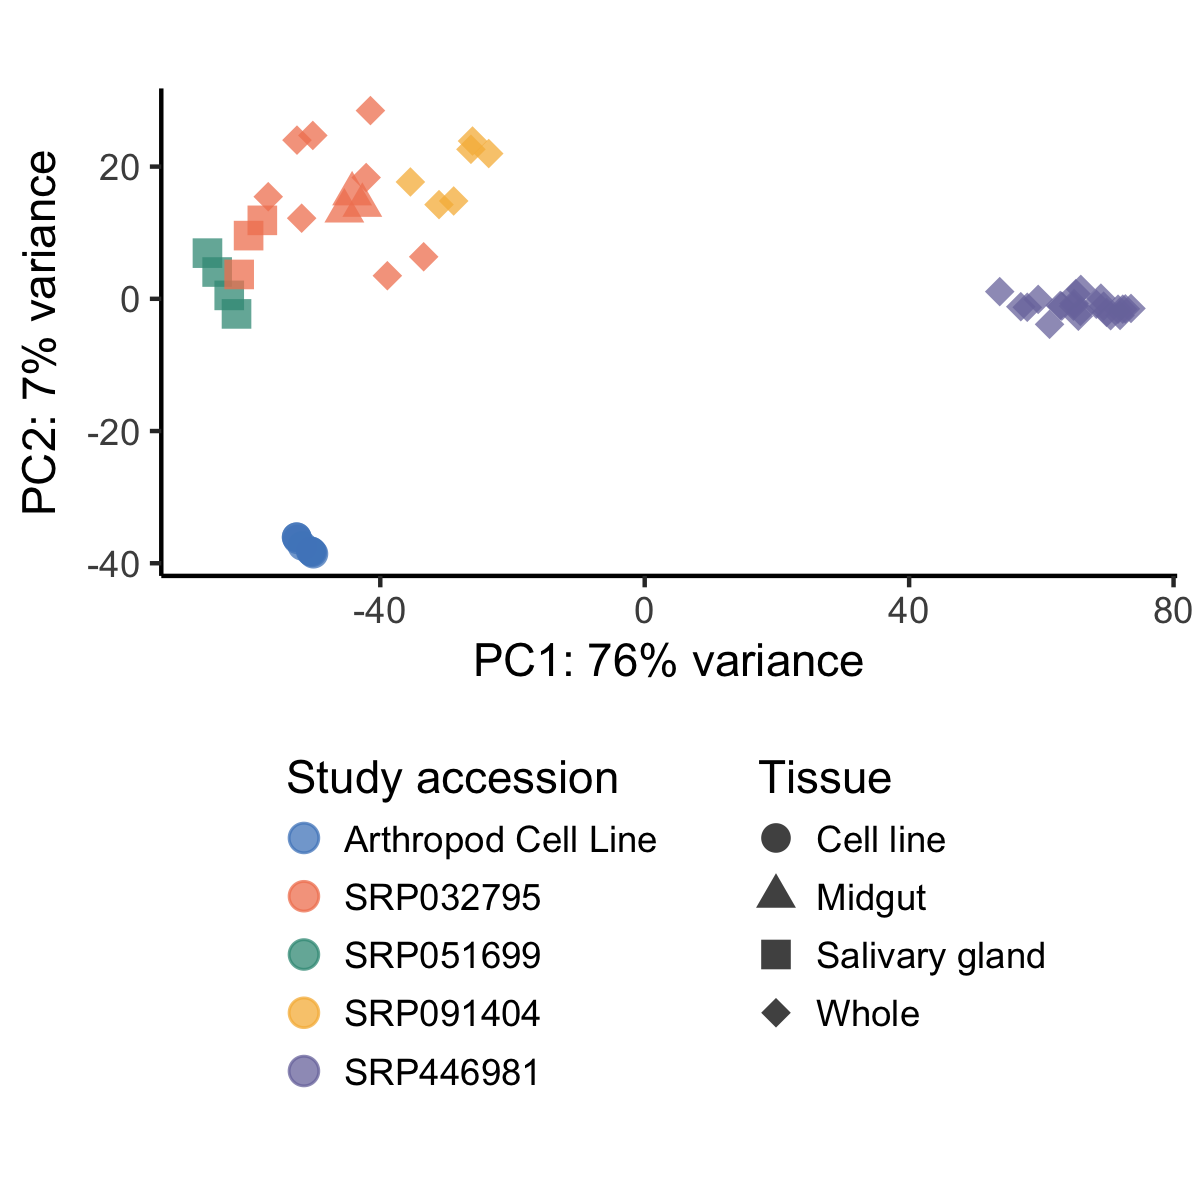

In [18]:
# turn the variance-stabilized counts (vsd) into a PCA analysis of the deseq object (pcad)
pcad <- plotPCA(vsd, intgroup = c("study_accession", "tissue", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(pcad, "percentVar"))
pcad <- pcad %>%
  mutate(tissue_plt = str_to_title(tissue),
         tissue_plt = gsub("_", " ", tissue_plt))

pca_plt <- ggplot(pcad, aes(PC1, PC2, color=study_accession, shape = tissue_plt)) +
  geom_point(size=3, alpha = 0.75) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  theme_classic() +
  theme(legend.position = "bottom",
        legend.title.position = "top",
        legend.key.size = unit(0.1, "cm"))+
  guides(color = guide_legend(nrow = 5, byrow = TRUE),
         shape = guide_legend(nrow = 4)) +
  scale_shape_manual(values=c(16, 17, 15, 18)) +
  scale_color_manual(values = accent_v2[1:5]) +
  labs(color = "Study accession", shape = "Tissue")

pca_plt

In [19]:
pdf("figures/pca.pdf", height = 4, width = 4)
pca_plt
dev.off()

pdf 
  2

In [20]:
width_in_inches <- 4 # corresponds to 1200 pixels at 300 dpi
height_in_inches <- 4 # keeps the aspect ratio

png(filename = "figures/pca.png", 
    width = width_in_inches, 
    height = height_in_inches, 
    units = "in", 
    res = 300, 
    type = "cairo-png")  # Using Cairo for better font rendering
pca_plt
dev.off()


pdf 
  2

In [21]:
svg("figures/pca.svg", height = 4, width = 4)
pca_plt
dev.off()

pdf 
  2

In [22]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] DESeq2_1.42.0               SummarizedExperiment_1.32.0
 [3] Biobase_2.62.0              MatrixGenerics_1.14.0      
 [5] matrixStats_1.3.0           GenomicRanges_1.54.1       
 [7] GenomeInfoDb_1.38.1         IRanges_2.36.0             
 [9] S4Vectors_0.40.2            BiocGenerics_0.48.1        
[11] lubridate_1.9.3             forcats_1.0.0              
[13] stringr_1.5.1               dplyr_1.1.4                
[15] purrr_1.0.2                 readr_2.1.5       